Importing required libraries

In [0]:
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Flatten, Add, Activation
from keras.layers import Input, concatenate, add
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

Using TensorFlow backend.


Function for adding BatchNormalization and ReLu activation

In [0]:
def BN_Relu(y):
  y = BatchNormalization()(y)
  return Activation('relu')(y)

Function to add a ResNet Block:  

> BN -> ReLu -> Conv2D with stride of 1 or 2 -> BN -> ReLu -> Conv2D with stride of 1

If input variable **'residue'** is true, we add an Identity shortcut (1x1 with stride of 2) from the first ReLu to the overall output of this ResNet Block  

Stride of 1 or 2 for the first Conv2D layer is decided based on the variable **'max_pool'**. Since a stride of 2 gives the effect of a maxpooling layer, if the 'max_pool' is true, we take a stride of 2 for the Conv2D layer






In [0]:
def ResBlock(y, c_out, k, residue=False, max_pool=False):
  y = BN_Relu(y)
  if(max_pool):
    z = Conv2D(filters=c_out, strides=2, kernel_size=k, border_mode="same")(y)
  else:
    z = Conv2D(filters=c_out, strides=1, kernel_size=k, border_mode="same")(y)
  z = BN_Relu(z)
  z = Conv2D(filters=c_out, strides=1, kernel_size=k, border_mode="same")(z)
  if(residue):
    y = Conv2D(filters=c_out, strides=2, kernel_size=1, border_mode="same")(y)
  #return y + z
  return add([y,z])

### ResNet18 has a configuration of (2,2,2,2) , i.e each ResNet Layer has 2 ResNet blocks 
B1 is the first ResNet layer. The number of channels for B1 is fixed (64 channels) and kernel size is 3. We do not desire a maxpooling effect in the first layer, we are not setting the 'max_pool' parameter of ResBlock function to true

In [0]:
def B1(y, c_out=64, k=3):
  y = ResBlock(y, c_out, k)
  return ResBlock(y, c_out, k)

Bx is used for the next 3 layers.  
Max pooling effect is desired in the start for each of these layers. These layers have a residual connection.

In [0]:
def Bx(y, c_out, k=3):
  y = ResBlock(y, c_out, k, residue=True, max_pool=True)
  return ResBlock(y, c_out, k)

The 2nd ResNet layer has 128 channels  
3rd ResNet layer has 256 channels  
4th ResNet layer has 512 channels 

In [0]:
x1 = Input(shape=(32, 32, 3))
x2 = Conv2D(filters=64, strides=1, kernel_size=3, padding="same")(x1)
x3 = BN_Relu(x2)
blk1 = B1(x3)
blk2 = Bx(blk1, 128)
blk3 = Bx(blk2, 256)
blk4 = Bx(blk3, 512)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, strides=1, kernel_size=3, padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, strides=1, kernel_size=3, padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=128, strides=2, kernel_size=3, padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=128, strides=1, kernel_size=3, padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=128, strides=2, kernel_size=1, padding="same")`
  # Remove the CW

In [0]:
maxpool = MaxPooling2D((4, 4))(blk4)
avgPool = AveragePooling2D ((4, 4))(blk4)

x = concatenate ([maxpool, avgPool])
x = Conv2D (10, 1, name = 'linear')(x)
x = Flatten ()(x)

x = Activation ('softmax')(x)

In [0]:
model = Model(inputs=x1, outputs=x)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

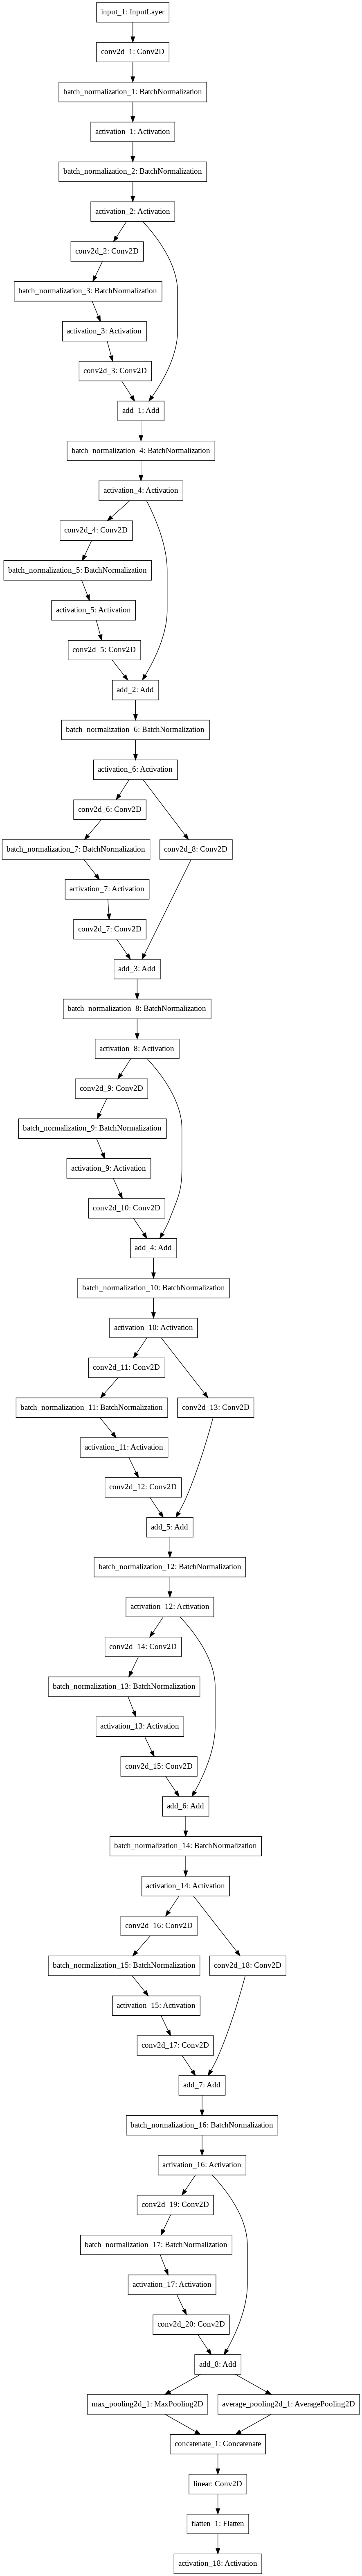

In [0]:
plot_model(model)

Setting horizontal flip data augmentation to false initially

In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

Loading CIFAR-10 dataset

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Callback implementing triangular cyclic learning rate scheduler with base learning rate as 0.01 and maximum learning rate as 0.1

In [0]:

from keras.callbacks import Callback
from keras import backend as K
import numpy as np


class CyclicLR (Callback):
    def __init__(
            self,
            base_lr=0.001,
            max_lr=1,
            step_size=2000,
            mode='triangular',
            gamma=1.,
            scale_fn=None,
            scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2',
                        'exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def optimized_clr (self):
      if self.clr_iterations > (2 * self.step_size):
        temp_step = self.step_size / 4
        cycle = np.floor(1 + self.clr_iterations / (2 * temp_step))
        x = np.abs(self.clr_iterations / temp_step - 2 * cycle + 1)
        return self.base_lr - (self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
      else:
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
      
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.optimized_clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

            
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        
clr = CyclicLR(
	mode='triangular',
	base_lr=0.005,
	max_lr=0.1,
	step_size= 20 * (train_features.shape[0] // 128))

Function to calculate model accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Mounting Google drive file system to save models

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/Colab_Models/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Defining ModelCheckpoint callback for saving the best model based on validation accuracy

In [0]:
filepath=root_path+'model_assignment_13_{val_acc:.6f}.h5'
checkpoint = ModelCheckpoint(filepath, save_best_only=True,monitor='val_acc')

Training the model for 50 epochs, with a batch size of 128

In [0]:
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=[clr,checkpoint])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<__main__..., steps_per_epoch=390, epochs=50)`
  This is separate from the ipykernel package so we can avoid doing imports until




Epoch 1/50
390/390 [==============================] - 63s 161ms/step - loss: 1.8931 - acc: 0.3359 - val_loss: 2.0112 - val_acc: 0.3315
Epoch 2/50
390/390 [==============================] - 54s 139ms/step - loss: 1.4436 - acc: 0.4857 - val_loss: 2.7430 - val_acc: 0.3275
Epoch 3/50
390/390 [==============================] - 54s 139ms/step - loss: 1.1833 - acc: 0.5781 - val_loss: 1.7808 - val_acc: 0.4516
Epoch 4/50
390/390 [==============================] - 54s 139ms/step - loss: 0.9990 - acc: 0.6474 - val_loss: 2.3204 - val_acc: 0.4189
Epoch 5/50
390/390 [==============================] - 54s 139ms/step - loss: 0.8335 - acc: 0.7075 - val_loss: 1.1669 - val_acc: 0.6072
Epoch 6/50
390/390 [==============================] - 54s 140ms/step - loss: 0.6700 - acc: 0.7655 - val_loss: 1.6849 - val_acc: 0.5205
Epoch 7/50
390/390 [==============================] - 54s 139ms/step - loss: 0.5505 - acc: 0.8122 - val_loss: 1.4566 - val_acc: 0.5743
Epoch 8/50
390/390 [==============================] -

**Function to plot the model accuracy and loss against epochs**

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

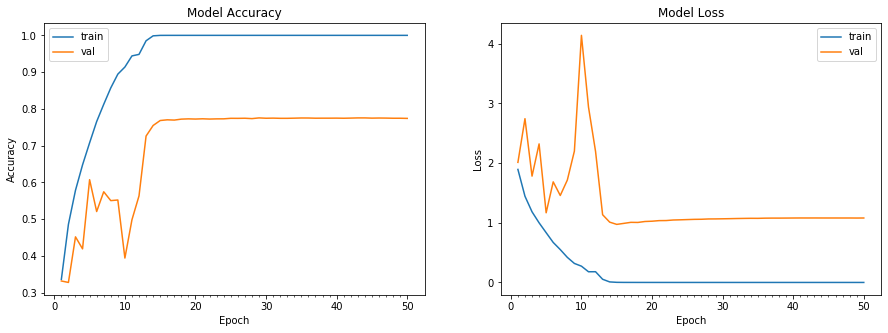

In [0]:
plot_model_history(model_info)

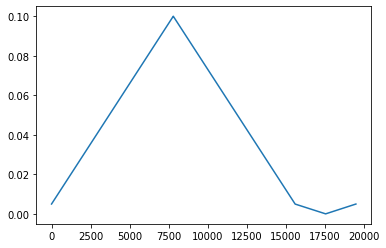

In [0]:
plt.plot(clr.history['iterations'], clr.history['lr'])

In [0]:
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data is: 77.40


### **Adding Data Augmentation - Horizontal flip of 0.5**

In [0]:
model2 = Model(inputs=x1, outputs=x)

In [0]:
model2.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=0.5)

In [0]:
model2_info = model2.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=[clr,checkpoint])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<__main__..., steps_per_epoch=390, epochs=50)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
390/390 [==============================] - 55s 140ms/step - loss: 0.4121 - acc: 0.8940 - val_loss: 0.8891 - val_acc: 0.7675
Epoch 2/50
390/390 [==============================] - 54s 139ms/step - loss: 0.2589 - acc: 0.9249 - val_loss: 0.8532 - val_acc: 0.7728
Epoch 3/50
390/390 [==============================] - 54s 139ms/step - loss: 0.1880 - acc: 0.9438 - val_loss: 0.8306 - val_acc: 0.7723
Epoch 4/50
390/390 [==============================] - 54s 139ms/step - loss: 0.1518 - acc: 0.9561 - val_loss: 0.8153 - val_acc: 0.7762
Epoch 5/50
390/390 [==============================] - 54s 139ms/step - loss: 0.1334 - acc: 0.9617 - val_loss: 0.8129 - val_acc: 0.7754
Epoch 6/50
390/390 [==============================] - 54s 139ms/step - loss: 0.1284 - acc: 0.9632 - val_loss: 0.8122 - val_acc: 0.7772
Epoch 7/50
390/390 [==============================] - 54s 139ms/step - loss: 0.1238 - acc: 0.9652 - val_loss: 0.8117 - val_acc: 0.7758
Epoch 8/50
390/390 [==============================] - 5

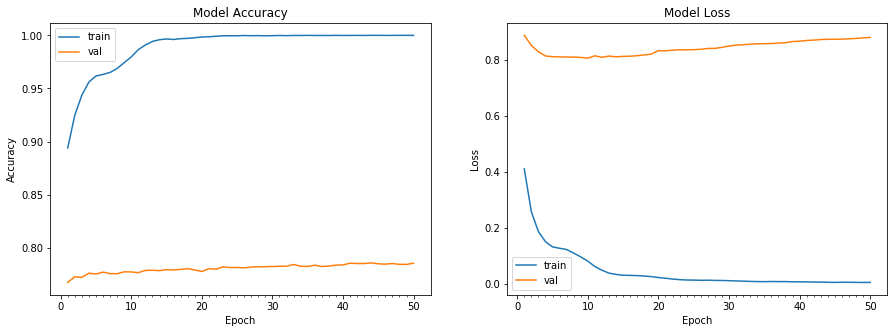

In [0]:
plot_model_history(model2_info)

In [0]:
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model2))

Accuracy on test data is: 78.56
